In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna

In [20]:
# Load your dataset

data = pd.read_excel("Gold_price_gbp.xlsx",index_col="Date", parse_dates=True)

In [21]:
# Prepare the data
def create_features(data, lags=1):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['GBP'].shift(lag)
    df.dropna(inplace=True)
    return df

lags = 5  # Number of lagged features
df = create_features(data, lags)

In [22]:
# Split the data into train and test sets
X = df.drop(columns=['GBP'])
y = df['GBP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)



In [23]:
# Define the objective function for Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    error = mean_squared_error(y_test, preds)
    return error

In [24]:
# Optimize the hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_params = study.best_params

# Train the final model with best parameters
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)
preds = model.predict(X_test)

[I 2024-06-09 11:18:50,679] A new study created in memory with name: no-name-0d486661-b1f8-4a6a-bdb4-8d8bd99dcfdc
[I 2024-06-09 11:18:50,962] Trial 0 finished with value: 57249.972908743934 and parameters: {'n_estimators': 84, 'max_depth': 10, 'learning_rate': 0.06014786848887986, 'subsample': 0.7949025814823212, 'colsample_bytree': 0.6815993114175317}. Best is trial 0 with value: 57249.972908743934.
[I 2024-06-09 11:18:51,290] Trial 1 finished with value: 57249.35474601844 and parameters: {'n_estimators': 757, 'max_depth': 1, 'learning_rate': 0.023908051500699135, 'subsample': 0.8441366756728571, 'colsample_bytree': 0.8714439198532586}. Best is trial 1 with value: 57249.35474601844.
[I 2024-06-09 11:18:56,200] Trial 2 finished with value: 53450.582494130846 and parameters: {'n_estimators': 580, 'max_depth': 15, 'learning_rate': 0.11184120814551447, 'subsample': 0.6190433707252947, 'colsample_bytree': 0.8237580982640158}. Best is trial 2 with value: 53450.582494130846.
[I 2024-06-09 11

In [25]:
# Evaluation metrics
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - preds) / y_test)) * 100
smape = np.mean(np.abs(preds - y_test) / ((np.abs(y_test) + np.abs(preds)) / 2)) * 100
mase = mae / np.mean(np.abs(np.diff(y_train)))
r2 = r2_score(y_test, preds)

# Print the evaluation metrics
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'sMAPE: {smape}')
print(f'MASE: {mase}')
print(f'R2: {r2}')

MAE: 151.64867691885237
MSE: 52402.3656462582
RMSE: 228.91562997370494
MAPE: 10.39200370515951
sMAPE: 11.66096351966462
MASE: 52.99232486510193
R2: 0.32912347114226514


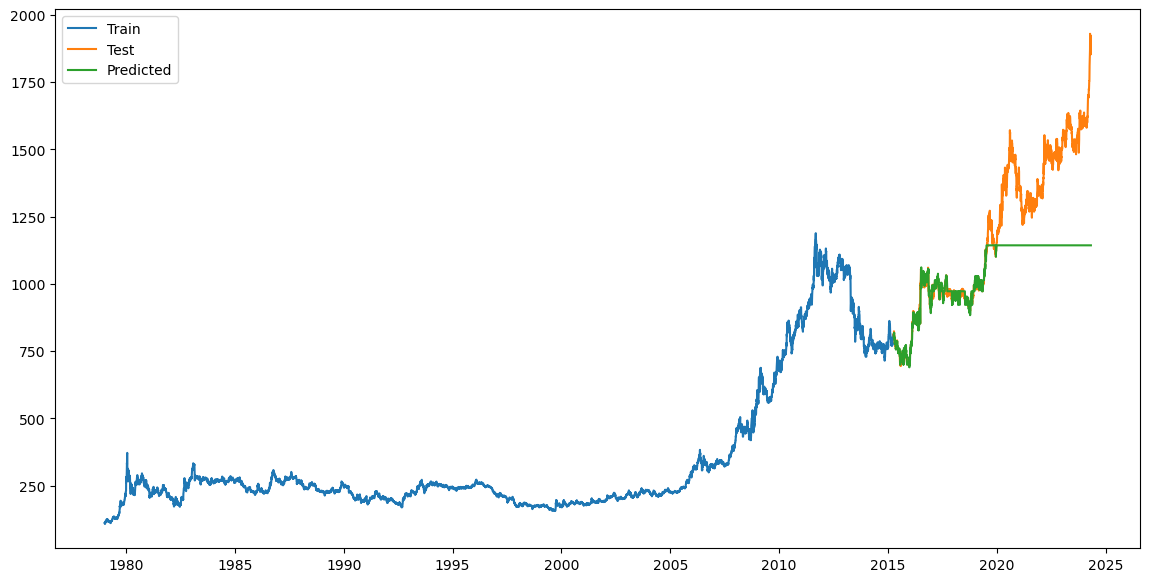

In [26]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, preds, label='Predicted')
plt.legend()
plt.show()